## PR曲線について
### PR曲線とは
ROC曲線の親戚です。PrecisionとRecallを使って書かれます。(これについては後述で詳しく説明します。)
### どんなときにPR曲線を使うのか
インバランスデータ(著しくPositiveに対してNegativeが多いデータ)に使われます。異常検知問題のデータセットはほとんどがこういう場合です。異常がPositive、正常がNegativeになります。

## 前提知識
### ROC曲線
このブログにたどり着いている方はROC曲線の概要は知っていると思いますので割愛します。step by stepで書き方を言える自信がないかたは、過去のブログ記事を見てください。
**ここにリンク挿入**

### Confusion Matrix
TP, FN, FP, TNの意味がわかれば充分だと思います。わからない方はこちらへ
http://rindalog.blogspot.jp/2014/12/confusion-matrix.html

### PrecisionとRecall
Wikipediaの図がわかりやすいです。
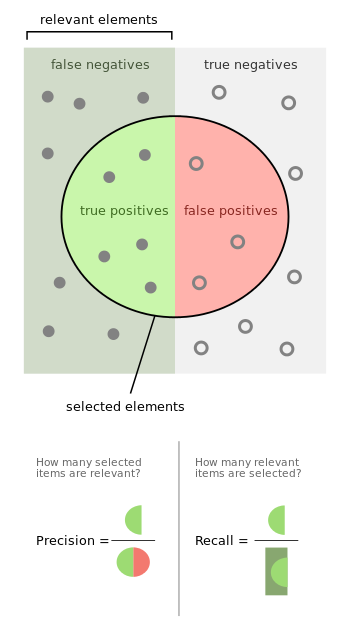
https://en.wikipedia.org/wiki/Precision_and_recall

先程のConfusion Matrixと関連します。Precisionは式で書くと
$$Precision = \frac{TP}{TP+FP}$$
で、「Positiveと選んだものの内、本当にPositiveだったのはどれぐらいか」を意味します。

Recallは式で書くと
$$Recall = \frac{TP}{TP+FN}$$
で、「本当はPositiveだったものの内、Positiveと選べたのはどれぐらいか」を意味します。
ROC曲線のTPRと同じ物を示してます。言い方が違うだけです。

インバランスデータではこの2つの指標が大事です。というのはPositiveがNegativeに比べて著しく少ないという仮定があるからです。例えばposが1個、negが99個のテストデータがあったときを想定してみましょう。そして判別器は100個すべてnegだと判別したと仮定しましょう。このとき正答率(Accuracy)を求めると、
$$Accuracy = \frac{99}{100} = 99\ [\%]$$
となります。しかし、異常検知等で知りたいposを当てることができていません。一方RecallやPrecisionならばposを当てた数によって変動するので、よりインバランスデータの評価に向いていることがわかります。またこれを使って描いているPR曲線もなんとなくインバランスデータの評価に適しているんじゃないかと推測できます。

## PR曲線の書き方
基本的にはROC曲線の書き方と同じです。これでピンと来ない方は過去のブログ記事を見てください。**リンク挿入**
では実際に描いてみようと思います。

In [ ]:
##import
from IPython.core.display import display
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

In [ ]:
df = pd.DataFrame({
    'prob': [0.99*0.05*x for x in range(20,0,-1)],
    'actual_label': [1]*3 + [0]*17,
})
df = df[['prob', 'actual_label']]
df

こんなデータを用意してみました、probが1(Positive)である確率を示しています。判別器にデータを突っ込んだ結果とでも思ってください。actual_labelが実際にPositiveかどうか示しています。1が少ないのはインバランスデータを意識しています。判別の閾値(Threshold)を0.85にでもおけばきれいに1と0を判別できます。

ここからPR曲線を書くために、閾値を動かしたときのRecallとPrecisionを求めます。

In [ ]:
for i in [0.01*x for x in range(95, -1 , -5)]:
    df['pred_label'] = (df.prob > i).astype(int)
    tn, fp, fn, tp = confusion_matrix(df.actual_label, df.pred_label, ).ravel()
    print('Threshold=',f"{i:.2f}",'\tRecall=',f"{tp/(tp+fn):.2f}",'\tPrecision=',f"{tp/(tp+fp):.2f}")

横軸にRecallを取り、縦軸にPrecisionを取って、軌跡(トラジェクトリ)を書いて完成です。すでにお気づきかもしれませんが、正方形となります。ちょっと描いてみます。

In [ ]:
##visualization
from ipywidgets import interact
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
from bokeh.layouts import gridplot
from bokeh.resources import INLINE
output_notebook(resources=INLINE)
##外出先でこのnotebookを書いてたのでofflineでBokehJSを取得できるようにしました。

In [ ]:
precision, recall, thresholds = precision_recall_curve(df.actual_label, df.prob, pos_label=1)
##なんでこの関数、ROCを返す関数と縦軸横軸順番逆に返すんだよ(# ﾟДﾟ)

##make figure
p = figure(
    title = "理想的なPR曲線", 
    plot_width=400, plot_height=400,
    x_range=(-0.02,1.02), y_range=(0,1.02)
)
##add line
p.line(
    recall,
    precision,
    line_width = 2,
)

##add rectangle
p.quad(
    top=1, bottom=0, left=0, right=1,
    alpha = 0.2
)

p.xaxis.axis_label = 'Recall'
p.yaxis.axis_label = 'Precision'

show(p)
print('AUCスコア:',average_precision_score(df.actual_label, df.prob))

ちゃんと正方形になりました。PR曲線のAUCスコアも計算すると1になりました。モデルがうまく機能してきちんとPositiveとNegativeを分離できる場合には、PR曲線はROC曲線と同じ性質を示すようです。

計算しませんがROC曲線のAUCも当然1となります。

## インバランスデータにおけるPR曲線とROC曲線の違い
ここではPR曲線がなぜインバランスデータの評価に適しているのか示します。理論はともかく、図的に視覚的に示していきます。
### 面積の比較
#### ちょっと悪い場合
先程のインバランスデータにおいて、2番目のactual_labelと3番目のを入れ替えました(0番目と1番目はそのまま)。

In [ ]:
df = pd.DataFrame({
    'prob': [0.99*0.05*x for x in range(20,0,-1)],
    'actual_label': [1]*2 + [0] + [1] + [0]*16,
})
df = df[['prob', 'actual_label']]
df

これを使って、PR曲線とROC曲線を描いて比較します。またAUCスコアの比較もしていきます。

In [ ]:
##PR
precision, recall, thresholds = precision_recall_curve(df.actual_label, df.prob, pos_label=1)

##make figure
s1 = figure(
    title = "PR曲線", 
    plot_width=300, plot_height=300,
    x_range=(-0.02,1.02), y_range=(0,1.02)
)
##add line
s1.line(
    recall,
    precision,
    line_width = 2,
)

##add patch
s1.patch(
    np.hstack((recall, 0, 1)),
    np.hstack((precision, 0, 0)),
    alpha = 0.2
)

s1.xaxis.axis_label = 'Recall'
s1.yaxis.axis_label = 'Precision'

##ROC
fpr, tpr, thresholds = roc_curve(df.actual_label, df.prob, pos_label=1)

##make figure
s2 = figure(
    title = "ROC曲線", 
    plot_width=300, plot_height=300,
    x_range=(-0.02,1.02), y_range=(0,1.02)
)
##add line
s2.line(
    fpr,
    tpr,
    line_width = 2
)

s2.patch(
    np.hstack((fpr, 1, 0)),
    np.hstack((tpr, 0, 0)),
    alpha = 0.2
)

s2.xaxis.axis_label = 'FPR'
s2.yaxis.axis_label = 'TPR'

p = gridplot([[s1, s2]])

show(p)
print('PR曲線のAUCスコア:',average_precision_score(df.actual_label, df.prob),'\tROC曲線のAUCスコア:',roc_auc_score(df.actual_label, df.prob))

見ての通り、PR曲線はROC曲線と違い右上が欠けました。重要なのはAUCスコアの方です。PR曲線のAUCは完璧なモデルと比べて0.085ほど減少しているのに対し、ROC曲線のAUCは0.02しか減少してません。インバランスデータにおいてPR曲線のAUCのほうが過敏なのです。

#### もっと悪い場合
上位から[1,0]を四回繰り返し、以下のようなデータを作りました。

In [ ]:
df = pd.DataFrame({
    'prob': [0.99*0.05*x for x in range(20,0,-1)],
    'actual_label': [1, 0]*4 + [0]*12,
})
df = df[['prob', 'actual_label']]
df

この面積も同様に見ていきます。

In [ ]:
##PR
precision, recall, thresholds = precision_recall_curve(df.actual_label, df.prob, pos_label=1)

##make figure
s1 = figure(
    title = "PR曲線", 
    plot_width=300, plot_height=300,
    x_range=(-0.02,1.02), y_range=(0,1.02)
)
##add line
s1.line(
    recall,
    precision,
    line_width = 2,
)

##add patch
s1.patch(
    np.hstack((recall, 0, 1)),
    np.hstack((precision, 0, 0)),
    alpha = 0.2
)

s1.xaxis.axis_label = 'Recall'
s1.yaxis.axis_label = 'Precision'

##ROC
fpr, tpr, thresholds = roc_curve(df.actual_label, df.prob, pos_label=1)

##make figure
s2 = figure(
    title = "ROC曲線", 
    plot_width=300, plot_height=300,
    x_range=(-0.02,1.02), y_range=(0,1.02)
)
##add line
s2.line(
    fpr,
    tpr,
    line_width = 2
)

s2.patch(
    np.hstack((fpr, 1, 0)),
    np.hstack((tpr, 0, 0)),
    alpha = 0.2
)

s2.xaxis.axis_label = 'FPR'
s2.yaxis.axis_label = 'TPR'

p = gridplot([[s1, s2]])

show(p)
print('PR曲線のAUCスコア:',average_precision_score(df.actual_label, df.prob),'\tROC曲線のAUCスコア:',roc_auc_score(df.actual_label, df.prob))

PR曲線のAUCは目に見えて減少が激しいです。どうしてこのように面積に大きな違いが出るのか次で見ていきます。

### 軌跡の比較
なぜこのように面積に違いが出るのかトラジェトリを一画一画追っていくことで可視化しようと思います。データはちょっと悪い場合を使います。

In [ ]:
df = pd.DataFrame({
    'prob': [0.99*0.05*x for x in range(20,0,-1)],
    'actual_label': [1]*2 + [0] + [1] + [0]*16,
})
df = df[['prob', 'actual_label']]
display(df)
threshold = [1.0]
recall = [0]
precision = [1]
fpr = [0]
figlist = []
for i in [0.01*x for x in range(95, -1 , -5)]:
    df['pred_label'] = (df.prob > i).astype(int)
    tn, fp, fn, tp = confusion_matrix(df.actual_label, df.pred_label, ).ravel()
    threshold.append(i)
    recall.append(tp/(tp+fn))
    precision.append(tp/(tp+fp))
    fpr.append(fp/(fp+tn))

In [ ]:
def update(i=1):
    s1 = figure(
        title = "PR曲線", 
        plot_width=300, plot_height=300,
        x_range=(-0.02,1.02), y_range=(0,1.02)
    )
    ##add line
    s1_l = s1.line(
        recall[:i],
        precision[:i],
        line_width = 2,
    )

    ##add patch
    s1_p = s1.patch(
        recall[:i]+[recall[i-1], 0],
        precision[:i]+[0, 0],
        alpha = 0.2
    )

    s1_c = s1.circle(
        recall[i-1],
        precision[i-1],
        size = 10,
    )

    s1.xaxis.axis_label = 'Recall'
    s1.yaxis.axis_label = 'Precision'

    ##ROC
    ##make figure
    s2 = figure(
        title = "ROC曲線", 
        plot_width=300, plot_height=300,
        x_range=(-0.02,1.02), y_range=(0,1.02)
    )
    ##add line
    s2_l = s2.line(
        fpr[:i],
        recall[:i],
        line_width = 2
    )

    s2_p = s2.patch(
        fpr[:i]+[fpr[i-1],0],
        recall[:i]+[0,0],
        alpha = 0.2
    )

    s2_c = s2.circle(
        fpr[i-1],
        recall[i-1],
        size = 10,
    )

    s2.xaxis.axis_label = 'FPR'
    s2.yaxis.axis_label = 'TPR'

    p = gridplot([[s1, s2]])
    show(p)
interact(update, i=(1,21))
##ホントはデータソースだけ更新する実装の予定でしたがなぜか動かなかったので、図ごと全部更新する激重実装になってしまいました。
##まあとりあえずは動けばいいのです。

iはThresholdに対応していて、$$Threshold=1-i\times0.05$$になっています。またiはprobが大きいデータから何行目までを1と判定するかの指標になっています。(そうなるようにdfを設定した。)

1行目まで1と判別する(すべてを0と判別する)ときはまだ面積はありません。点しかないのであたりまえですね。iを2に動かしてみると(1行目だけ1と判別)、PR曲線では早速面積が生じました。

iを4まで動かしてはじめてROC曲線に面積が生じました。一方PR曲線の方はすでに面積が0.66程度生じました。これではPR曲線のほうが大きな面積になりそうな気がしますが、PR曲線にはすでに損失が発生しています。PR曲線においてプロットしたマーカーを見ると、大きく下がっています。これは0を外して1と予測してしまったために生じた損失だと理解してください。これが次の点と繋がったときに右上の面積が大きく欠けることになります。

iが5のとき(probの上位4行を1と判別したとき)、PR曲線の面積はすでに完成しました。これで面積は確定です。PR曲線はPositiveをすべて当て終わった時点で完成します。一方ROC曲線はまだまだ完成には程遠いです。

iが21まで行ってROC曲線はやっと完成しました。ここからもROC曲線は0の当たっている状況を面積に反映していることがわかります。

ここから以下のことがわかります。

## まとめ

* ROC曲線はデータ全体に対してThresholdを変えて評価している。(従ってインバランスデータだと多いNegativeを当てるだけで面積が増えてしまう。)
* PR曲線はPositiveをすべて当て終わるThresholdまでのデータに対して、そこだけを拡大して評価している。(だからきちんとPositiveを当てないと面積が増えない。Negativeの多さにも引きづられにくい)

下図で説明する。PR曲線はオレンジ色の部分範囲をThresholdが動くと、それだけで面積が決定してしまう。一方ROC曲線は全範囲をThresholdが動いて面積がやっと決定する。よってPR曲線のほうが少ないPositiveに注目して評価する曲線だと言える。

In [ ]:
df.style.set_properties(**{'background-color': 'orange'}, subset=pd.IndexSlice[0:3,] )

ただ基本的な性質は同じです。

* 良いモデルならAUCが1に近づく。
* 悪いモデルなら面積が減る。
* PR-AUCが悪ければROC-AUCも悪い。逆も然り。

## 参考
実はここらへんに書いてあることを動かせるようにプログラミングし、自分なりに整理しただけです。

https://qiita.com/ogamiki/items/1ad297ca8761e00e0bca

https://qiita.com/skyshk/items/bfb3ad19b47b7ca94829

In [ ]:
for i in range(-1,4):
    df['pred_label'] = (df.prob > (0.95 - 0.05*i)).astype(int)
    display(df.style.set_properties(**{'background-color': 'orange'}, subset=pd.IndexSlice[0:i,]) )

In [ ]:
i=21
##PR
##make figure
s1 = figure(
    title = "PR曲線", 
    plot_width=300, plot_height=300,
    x_range=(-0.02,1.02), y_range=(0,1.02)
)
##add line
s1_l = s1.line(
    recall[:i],
    precision[:i],
    line_width = 2,
)

##add patch
s1_p = s1.patch(
    recall[:i]+[recall[i-1], 0],
    precision[:i]+[0, 0],
    alpha = 0.2
)

s1_c = s1.circle(
    recall[i-1],
    precision[i-1],
    size = 10,
)

s1.xaxis.axis_label = 'Recall'
s1.yaxis.axis_label = 'Precision'

##ROC
##make figure
s2 = figure(
    title = "ROC曲線", 
    plot_width=300, plot_height=300,
    x_range=(-0.02,1.02), y_range=(0,1.02)
)
##add line
s2_l = s2.line(
    fpr[:i],
    recall[:i],
    line_width = 2
)

s2_p = s2.patch(
    fpr[:i]+[fpr[i-1],0],
    recall[:i]+[0,0],
    alpha = 0.2
)

s2_c = s2.circle(
    fpr[i-1],
    recall[i-1],
    size = 10,
)

s2.xaxis.axis_label = 'FPR'
s2.yaxis.axis_label = 'TPR'

p = gridplot([[s1, s2]], title = 'a')
show(p)